In [200]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
#to get training and test data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer 
from sklearn.preprocessing import StandardScaler

In [201]:
input_file_path = r'T:\TOSHITH\PROGRAMMING\music_genere_classification\genres_processed'

In [ ]:
genere_names = sorted(os.listdir(input_file_path))

colums=['Amplitude_Envelope',
        "RMS_Energy",
        "Zero_Crossing_Rate",
        "SFOSE",
        "MFCC",
        "Delta_MFCC",
        "Delta2_MFCC"
        ,"Spectral_Centroid",
        "Spectral_Bandwidth",
        "Band_Energy_Ratio"
        ]

data=[]
lables=[]

for genere_name in genere_names:
    genere_path = os.path.join(input_file_path, genere_name)
    if not os.path.isdir(genere_path):
        continue
    audio_files = os.listdir(genere_path)
    for audio_files_csv in audio_files:
        features=[]
        df=pd.read_csv(os.path.join(genere_path,audio_files_csv))
        for i in colums:
            features.append(df[i])
        lables.append(genere_name)
        features=np.array(features)

        data.append(features)

data=np.array(data)
lables=np.array(lables)

lables= LabelBinarizer().fit_transform(lables)

In [203]:
data.shape,labels.shape

((999, 3, 323), (999, 10))

In [204]:
n_samples, timesteps, n_features = data.shape
data_2d = data.reshape(-1, n_features)
scaler = StandardScaler()
data_2d_scaled = scaler.fit_transform(data_2d)
data_scaled = data_2d_scaled.reshape(n_samples, timesteps, n_features)

In [205]:
data_scaled.shape
print(data_scaled.shape)
#you need to transpose axes to (999, 320, 10) for LSTM, because LSTM expects the sequence 
# length (timesteps) in the second dimension.
data_scaled = np.transpose(data_scaled, (0, 2, 1))   
print(data_scaled.shape)

(999, 3, 323)
(999, 323, 3)


In [206]:
#train test split 
audio_train, audio_test, label_train, label_test = train_test_split(
    data_scaled, labels, test_size=0.15, random_state=45, stratify=labels
)
audio_train.shape,label_train.shape,audio_test.shape,label_test.shape

((849, 323, 3), (849, 10), (150, 323, 3), (150, 10))

In [207]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv1D, MaxPooling1D
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Multiply, Concatenate

In [216]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout,
    MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Dense
)
import tensorflow as tf

# 1. CNN for Local Feature Extraction
input_layer = Input(shape=(audio_train.shape[1], audio_train.shape[2]))
x = Conv1D(128, kernel_size=3, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Conv1D(64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# 2. Transformer for Global Context
x = MultiHeadAttention(num_heads=4, key_dim=x.shape[-1])(x, x)
x = LayerNormalization(epsilon=1e-6)(x)
x = GlobalAveragePooling1D()(x)

# 3. Dense Layers for Classification
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(genere_names), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

In [217]:
#compile the model 
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)


#implementing for early stopping
import tensorflow 
early_stopping=tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [218]:
# 3. Train
model_history = model.fit(
    audio_train, label_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.0828 - loss: 2.8772 - val_accuracy: 0.0824 - val_loss: 2.3829
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1325 - loss: 2.3775 - val_accuracy: 0.0824 - val_loss: 2.4648
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1426 - loss: 2.3435 - val_accuracy: 0.0882 - val_loss: 2.5215
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1430 - loss: 2.2705 - val_accuracy: 0.0882 - val_loss: 2.5291
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1433 - loss: 2.2722 - val_accuracy: 0.1118 - val_loss: 2.5184
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1218 - loss: 2.3160 - val_accuracy: 0.0765 - val_loss: 2.5513
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1934 - loss: 2.2275 - val_accuracy: 0.1118 - val_loss: 2.5461
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1711 - loss: 2.2228 - val_accuracy: 0.

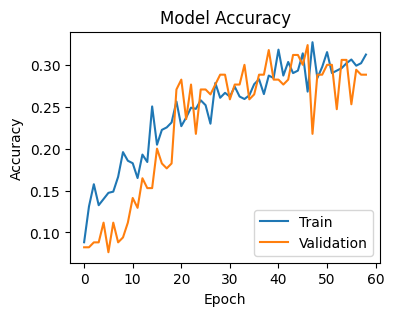

In [219]:
plt.figure(figsize=(4, 3))
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc="lower right")

plt.show()

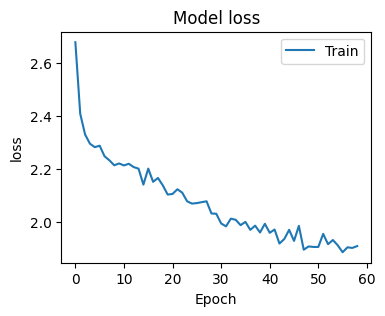

In [220]:
plt.figure(figsize=(4, 3))
plt.plot(model_history.history["loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(['Train'], loc="upper right")

plt.show()

In [223]:
from sklearn.metrics import accuracy_score

genre_predicted = model.predict(audio_test)
predicted_classes = np.argmax(genre_predicted, axis=1)
true_classes = np.argmax(label_test, axis=1)  # If label_test is one-hot
score = accuracy_score(true_classes, predicted_classes)
print("Accuracy:", score * 100, "%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 35.333333333333336 %


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


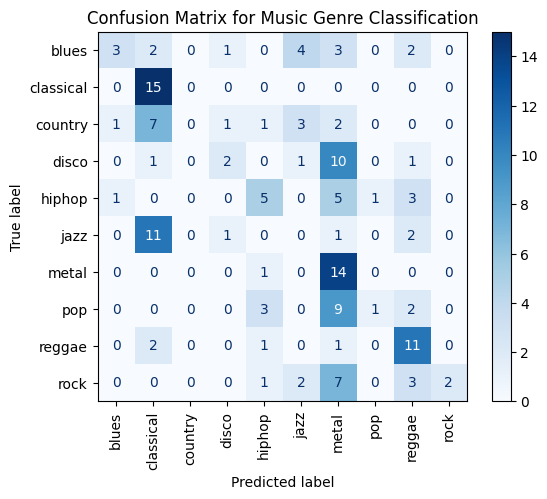

In [222]:
y_pred = model.predict(audio_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(label_test, axis=1)  # Convert one-hot to class indices
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_classes)
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genere_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')  # Rotate genre names for readability
plt.title('Confusion Matrix for Music Genre Classification')
plt.show()

In [212]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def transformer_encoder(inputs, head_size=128, num_heads=4, ff_dim=128, dropout=0.3):
    # Multi-head self-attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    # Feed-forward network
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

inputs = Input(shape=(audio_train.shape[1], audio_train.shape[2]))
x = BatchNormalization()(inputs)
x = transformer_encoder(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(genere_names), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001, clipvalue=0.5),
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_transformer.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    audio_train, label_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.1020 - loss: 2.3043 - val_accuracy: 0.0941 - val_loss: 2.2871
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.1241 - loss: 2.2921 - val_accuracy: 0.1294 - val_loss: 2.2667
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.1313 - loss: 2.2899 - val_accuracy: 0.1235 - val_loss: 2.2672
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.1757 - loss: 2.2656 - val_accuracy: 0.1412 - val_loss: 2.2202
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2155 - loss: 2.2399 - val_accuracy: 0.1294 - val_loss: 2.2418
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.1904 - loss: 2.2269 - val_accuracy: 0.1176 - val_loss: 2.2606
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.1879 - loss: 2.1942 - val_accuracy: 0.1059 - val_loss: 2.2875
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2147 - loss: 2.1785 - val_accuracy: 0.

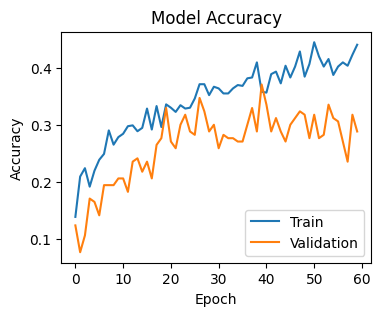

In [213]:
plt.figure(figsize=(4, 3))
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc="lower right")

plt.show()

In [214]:
from sklearn.metrics import accuracy_score

genre_predicted = model.predict(audio_test)
predicted_classes = np.argmax(genre_predicted, axis=1)
true_classes = np.argmax(label_test, axis=1)  # If label_test is one-hot
score = accuracy_score(true_classes, predicted_classes)
print("Accuracy:", score * 100, "%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Accuracy: 28.000000000000004 %


In [197]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    # First block: more filters, deeper
    Conv1D(256, kernel_size=5, activation='relu', input_shape=(audio_train.shape[1], audio_train.shape[2]), padding='same'),
    BatchNormalization(),
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    # Second block
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    # Third block
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    # Optional: GlobalAveragePooling1D instead of Flatten for variable-length inputs
    # GlobalAveragePooling1D(),
    Flatten(),

    # Dense layers
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(genere_names), activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001, clipvalue=0.5),
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_cnn.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    audio_train, label_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/200


c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.1328 - loss: 3.4372 - val_accuracy: 0.1765 - val_loss: 2.2936
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0630 - loss: 3.5189 - val_accuracy: 0.1235 - val_loss: 2.2966
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0941 - loss: 3.5321 - val_accuracy: 0.1176 - val_loss: 2.3035
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1395 - loss: 3.3422 - val_accuracy: 0.1118 - val_loss: 2.3096
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1206 - loss: 3.3710 - val_accuracy: 0.1176 - val_loss: 2.3115
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1054 - loss: 3.2453 - val_accuracy: 0.1471 - val_loss: 2.2934
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0971 - loss: 3.2907 - val_accuracy: 0.1765 - val_loss: 2.2406
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.1073 - loss: 3.2035 - val_accuracy: 0.2059 - val_l

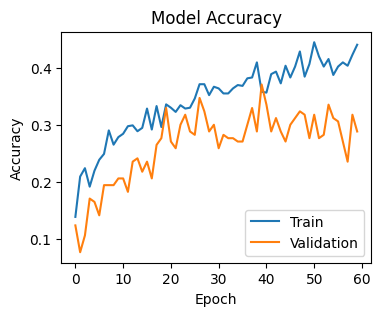

In [198]:
plt.figure(figsize=(4, 3))
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc="lower right")

plt.show()

In [199]:
from sklearn.metrics import accuracy_score

genre_predicted = model.predict(audio_test)
predicted_classes = np.argmax(genre_predicted, axis=1)
true_classes = np.argmax(label_test, axis=1)  # If label_test is one-hot
score = accuracy_score(true_classes, predicted_classes)
print("Accuracy:", score * 100, "%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Accuracy: 30.0 %
